In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = inputs
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

# Define the PINN loss function
def pinn_loss(model, x_u, t_u, x_v, t_v):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_u)
        tape.watch(t_u)
        tape.watch(x_v)
        tape.watch(t_v)

        u = model(tf.concat([x_u, t_u], axis=1))
        v = model(tf.concat([x_v, t_v], axis=1))

        du_dx = tape.gradient(u, x_u)
        dv_dx = tape.gradient(v, x_v)
        du_dt = tape.gradient(u, t_u)
        dv_dt = tape.gradient(v, t_v)

    du_dxx = tape.gradient(du_dx, x_u)
    dv_dxx = tape.gradient(dv_dx, x_v)

    pde_loss_u = du_dt - du_dxx - u + v * tf.math.tan(x_u)
    pde_loss_v = dv_dt - dv_dxx - v + u * tf.math.tan(x_v)

    loss = tf.reduce_mean(tf.square(pde_loss_u)) + tf.reduce_mean(tf.square(pde_loss_v))

    return loss

# Define the finite element method for comparison
def finite_element_method():
    N = 100
    x = np.linspace(0, np.pi, N)
    t = np.linspace(0, 1, N)
    print("x shape:", x.shape)
    print("t shape:", t.shape)
    x, t = np.meshgrid(x, t)
    x = x.flatten()
    t = t.flatten()
    print("Flattened x shape:", x.shape)
    print("Flattened t shape:", t.shape)

    # Constructing the coefficient matrix
    h = np.pi / (N - 1)
    main_diag = np.ones((N,)) * (1 + 2 * h ** 2)
    off_diag = np.ones((N - 1,)) * -1

    B = np.diag(main_diag) + np.diag(off_diag, -1) + np.diag(off_diag, 1)

    # Boundary conditions
    B[0, 0] = 1
    B[N - 1, N - 1] = 1

    # Right-hand side
    L = np.zeros(N)
    L[1:-1] = h ** 2 * np.sin(x[1:N-1]) * np.tan(x[1:N-1])
    L[0] = 0
    L[-1] = 0

    # Solve the system
    U = np.linalg.solve(B, L)

    return U.reshape(N, 1)

# Training loop for PINN
def train_pinns(model, x_u, t_u, x_v, t_v, iterations=1000, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Convert NumPy arrays to TensorFlow tensors
    x_u_tf = tf.convert_to_tensor(x_u, dtype=tf.float32)
    t_u_tf = tf.convert_to_tensor(t_u, dtype=tf.float32)
    x_v_tf = tf.convert_to_tensor(x_v, dtype=tf.float32)
    t_v_tf = tf.convert_to_tensor(t_v, dtype=tf.float32)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = pinn_loss(model, x_u_tf, t_u_tf, x_v_tf, t_v_tf)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if i % 100 == 0:
            print("Epoch {}, Loss: {}".format(i, loss.numpy()))

# Generate training data
N_u = 100
N_v = 100
x_u = np.random.rand(N_u, 1) * np.pi
t_u = np.random.rand(N_u, 1)
x_v = np.random.rand(N_v, 1) * np.pi
t_v = np.random.rand(N_v, 1)

# Define the PINN model
model = PINN()

# Train the PINN model
train_pinns(model, x_u, t_u, x_v, t_v)

# Generate points for plotting
x_plot = np.linspace(0, np.pi, 100)
t_plot = np.linspace(0, 1, 100)
x_plot, t_plot = np.meshgrid(x_plot, t_plot)
u_pred = model(tf.concat([x_plot.flatten()[:, None], t_plot.flatten()[:, None]], axis=1))
u_pred = u_pred.numpy().reshape(x_plot.shape)

# Compute finite element solution
u_fem = finite_element_method()

# Plot results using Plotly
fig = go.Figure()

# Plot PINN solution
fig.add_trace(go.Surface(x=x_plot, y=t_plot, z=u_pred, colorscale='Viridis', name="PINN Solution"))

# Plot finite element solution
fig.add_trace(go.Surface(x=x_plot, y=t_plot, z=u_fem, colorscale='Plasma', name="Finite Element Method"))

fig.update_layout(title="Comparison of PINN and Finite Element Method Solutions",
                  scene=dict(xaxis_title="x", yaxis_title="t", zaxis_title="u(x,t)"),
                  margin=dict(l=0, r=0, b=0, t=40))

fig.show()


Epoch 0, Loss: 2.9095458984375
Epoch 100, Loss: 0.0022520828060805798
Epoch 200, Loss: 0.001079339999705553
Epoch 300, Loss: 0.0008276227745227516
Epoch 400, Loss: 0.000668461318127811
Epoch 500, Loss: 0.000539979082532227
Epoch 600, Loss: 0.00043640079093165696
Epoch 700, Loss: 0.00035475625190883875
Epoch 800, Loss: 0.00029098684899508953
Epoch 900, Loss: 0.00024090951774269342
x shape: (100,)
t shape: (100,)
Flattened x shape: (10000,)
Flattened t shape: (10000,)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.graph_objects as go

# Define the PINN model
class PINN(keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense_u1 = layers.Dense(64, activation='relu')
        self.dense_v1 = layers.Dense(64, activation='relu')
        self.dense_u2 = layers.Dense(64, activation='relu')
        self.dense_v2 = layers.Dense(64, activation='relu')
        self.dense_u3 = layers.Dense(64, activation='relu')
        self.dense_v3 = layers.Dense(64, activation='relu')
        self.dense_t = layers.Dense(2, activation=None)

    def call(self, inputs):
        x = inputs[:, 0:1]
        t = inputs[:, 1:2]
        uv = tf.concat([x, t], axis=1)
        return self.dense_t(tf.concat([tf.sin(self.dense_u3(self.dense_u2(self.dense_u1(uv)))),
                                        tf.sin(self.dense_v3(self.dense_v2(self.dense_v1(uv))))], axis=1))

# Define loss function
def custom_loss(model):
    def loss_fn(x, t):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(t)
            inputs = tf.concat([x, t], axis=1)
            predictions = model(inputs)
            u = predictions[:, 0:1]
            v = predictions[:, 1:2]
            du_dt = tape.gradient(u, t)
            du_dx = tape.gradient(u, x)
            du_dx2 = tape.gradient(tf.gradients(u, x)[0], x)
            dv_dt = tape.gradient(v, t)
            dv_dx = tape.gradient(v, x)
            dv_dx2 = tape.gradient(tf.gradients(v, x)[0], x)
        del tape
        eq1_residual = du_dt - a1 * du_dx2 - u**2 * v + (b + 1) * u - r
        eq2_residual = dv_dt - a2 * dv_dx2 + u**2 * v - b * u
        # # Compute boundary condition residuals
        ic_loss_u = u[:, 0:1] - 0.5
        ic_loss_v = v[:, 0:1] - 1 - 5*x[:, 0:1]
        bc_loss_u = u[:, 0:1] - u[:, -1:]  # Adjusted for periodic boundary
        bc_loss_v = v[:, 0:1] - v[:, -1:]  # Adjusted for periodic boundary
        return tf.reduce_mean(tf.square(eq1_residual)) + tf.reduce_mean(tf.square(eq2_residual)) + tf.reduce_mean(tf.square(ic_loss_u)) + tf.reduce_mean(tf.square(ic_loss_v)) + tf.reduce_mean(tf.square(bc_loss_u)) + tf.reduce_mean(tf.square(bc_loss_v))
    return loss_fn

# Define parameters
a1 = 0.0001
a2 = 0.0001
b = 3.4
r = 1

# Define training data
x_train = np.linspace(0, 15, 200)[:, None]
t_train = np.linspace(0, 15, 200)[:, None]

# Create PINN model
model = PINN()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss(model), metrics=['mse'])

# Train the model
history = model.fit(
    x=np.concatenate([x_train, t_train], axis=1),
    y=np.zeros((len(x_train), 2)),
    epochs=1000,
    batch_size=32,
    verbose=1
)

# Plot true and predicted solutions
x_plot = np.linspace(0, 15, 200)
t_plot = np.linspace(0, 15, 200)
X_plot, T_plot = np.meshgrid(x_plot, t_plot)
inputs_plot = np.column_stack((X_plot.flatten(), T_plot.flatten()))

# Predict solutions using trained model
predictions = model.predict(inputs_plot)
u_pred = predictions[:, 0].reshape(X_plot.shape)
v_pred = predictions[:, 1].reshape(X_plot.shape)

# Plot predicted solutions for u
fig_u = go.Figure()
fig_u.add_trace(go.Surface(z=u_pred, x=X_plot, y=T_plot, colorscale='Plasma', name='Predicted Solution'))
fig_u.update_layout(title='Solution of u(x, t)',
                    scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='u(x,t)'))
fig_u.show()

# Plot predicted solutions for v
fig_v = go.Figure()
fig_v.add_trace(go.Surface(z=v_pred, x=X_plot, y=T_plot, colorscale='Plasma', name='Predicted Solution'))
fig_v.update_layout(title='Solution of v(x, t)',
                    scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='v(x,t)'))
fig_v.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.graph_objects as go

# Define the PINN model
class PINN(keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense_u1 = layers.Dense(20, activation=tf.nn.leaky_relu)
        self.dense_v1 = layers.Dense(20, activation=tf.nn.leaky_relu)
        self.dense_u2 = layers.Dense(20, activation=tf.nn.leaky_relu)
        self.dense_v2 = layers.Dense(20, activation=tf.nn.leaky_relu)
        # self.dense_u3 = layers.Dense(100, activation=tf.nn.leaky_relu)
        # self.dense_v3 = layers.Dense(100, activation=tf.nn.leaky_relu)
        # self.dense_u4 = layers.Dense(100, activation=tf.nn.leaky_relu)
        # self.dense_v4 = layers.Dense(100, activation=tf.nn.leaky_relu)
        # self.dense_u5 = layers.Dense(20, activation=tf.nn.leaky_relu)
        # self.dense_v5 = layers.Dense(20, activation=tf.nn.leaky_relu)
        # self.dense_u6 = layers.Dense(20, activation=tf.nn.leaky_relu)
        # self.dense_v6 = layers.Dense(20, activation=tf.nn.leaky_relu)
        # self.dense_u7 = layers.Dense(100, activation=tf.nn.leaky_relu)
        # self.dense_v7 = layers.Dense(100, activation=tf.nn.leaky_relu)
        # self.dense_u8 = layers.Dense(100, activation=tf.nn.leaky_relu)
        # self.dense_v8 = layers.Dense(100, activation=tf.nn.leaky_relu)
        self.dense_t = layers.Dense(2, activation=None)

    def call(self, inputs):
        x = inputs[:, 0:1]
        t = inputs[:, 1:2]
        uv = tf.concat([x, t], axis=1)
        return self.dense_t(tf.concat([tf.sin(self.dense_u2(self.dense_u1(uv))),
                                        tf.sin(self.dense_v2(self.dense_v1(uv)))], axis=1))
# Define custom loss function
def custom_loss(model):
    def loss_fn(x, t):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(t)
            inputs = tf.concat([x, t], axis=1)
            predictions = model(inputs)
            u = predictions[:, 0:1]
            # v = predictions[:, 1:2]
            du_dt = tape.gradient(u, t)
            du_dx = tape.gradient(u, x)
            du_dx2 = tape.gradient(tf.gradients(u, x)[0], x)
            # dv_dt = tape.gradient(v, t)
            # dv_dx = tape.gradient(v, x)
            # dv_dx2 = tape.gradient(tf.gradients(v, x)[0], x)
        eq1_residual = du_dt - a1 * du_dx2 - u**2 * v + (b + 1) * u - r
        # eq2_residual = dv_dt - a2 * dv_dx2 + u**2 * v - b * u
        ic_loss_u = u[:, 0:1] - 0.5
        # ic_loss_v = v[:, 0:1] - 1 - 5*x[:, 0:1]
        # bc_loss_u = u[:, 0:1] - u[:, -1:]
        # bc_loss_v = v[:, 0:1] - v[:, -1:]
        return tf.reduce_mean(tf.square(eq1_residual)) + tf.reduce_mean(tf.square(eq2_residual)) + \
               tf.reduce_mean(tf.square(ic_loss_u)) + tf.reduce_mean(tf.square(ic_loss_v)) + \
               tf.reduce_mean(tf.square(bc_loss_u)) + tf.reduce_mean(tf.square(bc_loss_v))
    return loss_fn

# Define parameters
a1 = 0.0001  # Adjusted learning rate
a2 = 0.0001  # Adjusted learning rate
b = 3.4
r = 1

# Define training data
x_train = np.linspace(0, 2, 200)[:, None]
t_train = np.linspace(0, 2, 200)[:, None]

# Create PINN model
model = PINN()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss(model), metrics=['mse'])

# Train the model
history = model.fit(
    x=np.concatenate([x_train, t_train], axis=1),
    y=np.zeros((len(x_train), 2)),
    epochs=2000,  # Increased epochs
    batch_size=32,
    verbose=1
)

# Plot true and predicted solutions
x_plot = np.linspace(0, 2, 200)
t_plot = np.linspace(0, 2, 200)
X_plot, T_plot = np.meshgrid(x_plot, t_plot)
inputs_plot = np.column_stack((X_plot.flatten(), T_plot.flatten()))

# Predict solutions using trained model
predictions = model.predict(inputs_plot)
u_pred = predictions[:, 0].reshape(X_plot.shape)
v_pred = predictions[:, 1].reshape(X_plot.shape)

# Plot predicted solutions for u
fig_u = go.Figure()
fig_u.add_trace(go.Surface(z=u_pred, x=X_plot, y=T_plot, colorscale='Plasma', name='Predicted Solution'))
fig_u.update_layout(title='Solution of u(x, t)',
                    scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='u(x,t)'))
fig_u.show()

# Plot predicted solutions for v
fig_v = go.Figure()
fig_v.add_trace(go.Surface(z=v_pred, x=X_plot, y=T_plot, colorscale='Plasma', name='Predicted Solution'))
fig_v.update_layout(title='Solution of v(x, t)',
                    scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='v(x,t)'))
fig_v.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print("Lowest Loss:", min(history.history['loss']))

Lowest Loss: 2.1072985023629087e-10


In [ ]:
# Define the value of t for which you want to plot the solutions
t_plot_value = 3

# Create input data for the specified value of t
x_plot_2d = np.linspace(0, 1, 2000)
t_plot_2d = np.full_like(x_plot_2d, fill_value=t_plot_value)
inputs_plot_2d = np.column_stack((x_plot_2d, t_plot_2d))

# Predict solutions using trained model for the specified value of t
predictions_2d = model.predict(inputs_plot_2d)
u_pred_2d = predictions_2d[:, 0]
v_pred_2d = predictions_2d[:, 1]

# Plot the predicted solutions for u and v at t = 10.3
fig_u_2d = go.Figure()
fig_u_2d.add_trace(go.Scatter(x=x_plot_2d, y=u_pred_2d, mode='lines', name='Predicted Solution for u'))
fig_u_2d.update_layout(title='Predicted Solution of u(x, t=3)', xaxis_title='x', yaxis_title='u(x, t=3)')
fig_u_2d.show()

fig_v_2d = go.Figure()
fig_v_2d.add_trace(go.Scatter(x=x_plot_2d, y=v_pred_2d, mode='lines', name='Predicted Solution for v'))
fig_v_2d.update_layout(title='Predicted Solution of v(x, t=3)', xaxis_title='x', yaxis_title='v(x, t=3)')
fig_v_2d.show()


63/63 [==============================] - 0s 2ms/step


In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import plotly.graph_objects as go

# # Define the PINN model with Fourier features
# class PINN(keras.Model):
#     def __init__(self, num_fourier_features):
#         super(PINN, self).__init__()
#         self.num_fourier_features = num_fourier_features
#         self.dense_u1 = layers.Dense(50, activation='relu')
#         self.dense_v1 = layers.Dense(50, activation='relu')
#         self.dense_u2 = layers.Dense(50, activation='relu')
#         self.dense_v2 = layers.Dense(50, activation='relu')
#         self.dense_u3 = layers.Dense(50, activation='relu')
#         self.dense_v3 = layers.Dense(50, activation='relu')
#         self.dense_t = layers.Dense(2, activation=None)

#     def call(self, inputs):
#         # Fourier features
#         fourier_features = self._fourier_features(inputs[:, 1], self.num_fourier_features)
#         inputs = tf.concat([inputs, fourier_features], axis=1)

#         x = inputs[:, 0:1]
#         t = inputs[:, 1:2]
#         uv = tf.concat([x, t], axis=1)
#         return self.dense_t(tf.concat([self.dense_u3(self.dense_u2(self.dense_u1(uv))), self.dense_v3(self.dense_v2(self.dense_v1(uv)))], axis=1))

#     def _fourier_features(self, x, num_features):
#         # Fourier features computation
#         t = tf.expand_dims(x, -1)
#         frequencies = tf.range(1, num_features + 1, dtype=tf.float32)
#         features = tf.concat([tf.sin(np.pi * t * frequencies), tf.cos(np.pi * t * frequencies)], axis=-1)
#         return features

# # Define loss function
# def custom_loss(model):
#     def loss_fn(x, t):
#         with tf.GradientTape(persistent=True) as tape:
#             tape.watch(x)
#             tape.watch(t)
#             inputs = tf.concat([x, t], axis=1)
#             predictions = model(inputs)
#             u = predictions[:, 0:1]
#             v = predictions[:, 1:2]
#             du_dt = tape.gradient(u, t)
#             du_dx = tape.gradient(u, x)
#             du_dx2 = tape.gradient(tf.gradients(u, x)[0], x)
#             dv_dt = tape.gradient(v, t)
#             dv_dx = tape.gradient(v, x)
#             dv_dx2 = tape.gradient(tf.gradients(v, x)[0], x)
#         del tape
#         eq1_residual = du_dt - a1 * du_dx2 - u**2 * v + (b + 1) * u - r
#         eq2_residual = dv_dt - a2 * dv_dx2 + u**2 * v - b * u
#         # # Compute boundary condition residuals
#         ic_loss_u = u[:, 0:1] - 0.5
#         ic_loss_v = v[:, 0:1] - 1 - 5*x[:, 0:1]
#         bc_loss_u = du_dx[:, 0:1] - du_dx[:, -1:]
#         bc_loss_v = dv_dx[:, 0:1] - dv_dx[:, -1:]
#         return tf.reduce_mean(tf.square(eq1_residual)) + tf.reduce_mean(tf.square(eq2_residual)) + tf.reduce_mean(tf.square(ic_loss_u)) + tf.reduce_mean(tf.square(ic_loss_v)) + tf.reduce_mean(tf.square(bc_loss_u)) + tf.reduce_mean(tf.square(bc_loss_v))
#     return loss_fn

# # Define parameters
# a1 = 0.0001
# a2 = 0.0001
# b = 3.4
# r = 1
# num_fourier_features = 100 # Number of Fourier features

# # Define training data
# x_train = np.linspace(0, 10, 200)[:, None]
# t_train = np.linspace(0, 15, 200)[:, None]

# # Create PINN model with Fourier features
# model = PINN(num_fourier_features)

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=custom_loss(model), metrics=['mse'])

# # Train the model
# history = model.fit(
#     x=np.concatenate([x_train, t_train], axis=1),
#     y=np.zeros((len(x_train), 2)),
#     epochs=1000,
#     batch_size=32,
#     verbose=1
# )

# # Plot true and predicted solutions
# x_plot = np.linspace(0, 10, 200)
# t_plot = np.linspace(0, 15, 200)
# X_plot, T_plot = np.meshgrid(x_plot, t_plot)
# inputs_plot = np.column_stack((X_plot.flatten(), T_plot.flatten()))

# # Evaluate true solutions
# def true_solution(x, t):
#     u_true = np.sin(x) * np.cos(t)
#     v_true = np.sin(x) * np.sin(t)
#     return u_true, v_true

# u_true, v_true = true_solution(X_plot, T_plot)

# # Predict solutions using trained model
# predictions = model.predict(inputs_plot)
# u_pred = predictions[:, 0].reshape(X_plot.shape)
# v_pred = predictions[:, 1].reshape(X_plot.shape)

# # Plot true and predicted solutions for u
# fig_u = go.Figure()
# #fig_u.add_trace(go.Surface(z=u_true, x=X_plot, y=T_plot, colorscale='Viridis', name='True Solution'))
# fig_u.add_trace(go.Surface(z=u_pred, x=X_plot, y=T_plot, colorscale='Plasma', name='Predicted Solution'))
# fig_u.update_layout(title='Solution of u(x, t)',
#                     scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='u(x,t)'))
# fig_u.show()

# # Plot true and predicted solutions for v
# fig_v = go.Figure()
# #fig_v.add_trace(go.Surface(z=v_true, x=X_plot, y=T_plot, colorscale='Viridis', name='True Solution'))
# fig_v.add_trace(go.Surface(z=v_pred, x=X_plot, y=T_plot, colorscale='Plasma', name='Predicted Solution'))
# fig_v.update_layout(title='Solution of v(x, t)',
#                     scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='v(x,t)'))
# fig_v.show()



In [ ]:
# # Define the value of t for which you want to plot the solutions
# t_plot_value = 3

# # Create input data for the specified value of t
# x_plot_2d = np.linspace(0, 5, 2000)
# t_plot_2d = np.full_like(x_plot_2d, fill_value=t_plot_value)
# inputs_plot_2d = np.column_stack((x_plot_2d, t_plot_2d))

# # Predict solutions using trained model for the specified value of t
# predictions_2d = model.predict(inputs_plot_2d)
# u_pred_2d = predictions_2d[:, 0]
# v_pred_2d = predictions_2d[:, 1]

# # Plot the predicted solutions for u and v at t = 10.3
# fig_u_2d = go.Figure()
# fig_u_2d.add_trace(go.Scatter(x=x_plot_2d, y=u_pred_2d, mode='lines', name='Predicted Solution for u'))
# fig_u_2d.update_layout(title='Predicted Solution of u(x, t=10.3)', xaxis_title='x', yaxis_title='u(x, t=10.3)')
# fig_u_2d.show()

# fig_v_2d = go.Figure()
# fig_v_2d.add_trace(go.Scatter(x=x_plot_2d, y=v_pred_2d, mode='lines', name='Predicted Solution for v'))
# fig_v_2d.update_layout(title='Predicted Solution of v(x, t=10.3)', xaxis_title='x', yaxis_title='v(x, t=10.3)')
# fig_v_2d.show()


In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from scipy.integrate import odeint
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the system of differential equations
def system_model(variables, t):
    x, y = variables
    dxdt = x * ((4+ (1/2) * np.sin(t))/(1+(3 + (1/2) * np.cos(t)) * y)- (1 + (1/4) * np.cos(t)) * x - (1 + (1/5) * np.cos(t)) * y/((3/5) + (27/100) * np.sin(t) + ((3/10)+(1/2) * np.sin(t)) * x + ((1/2)+(1/10) * np.sin(t)) * y + (2+(3/10) * np.sin(t)) * x * y))
    dydt = y * (-((3/5) + (1/2) * np.cos(t))  - (3 + (3.2) * np.cos(t)) * y  + (2 + np.cos(t)) * x /((3/5) + (27/100) * np.sin(t) + ((3/10)+(1/2) * np.sin(t)) * x + ((1/2)+(1/10) * np.sin(t)) * y + (2+(3/10) * np.sin(t)) * x * y)   )
    return [dxdt, dydt]

# Generate synthetic data
t = np.linspace(0, 100, 2000)
initial_conditions = [1.5, 0.5]
# a = 0.091
# b = 0.061
true_solution_system = odeint(system_model, initial_conditions, t)
# Define input features
input_features = np.column_stack([t, np.sin(t), np.cos(t)])
# Generate sample training points
sample_indices = np.random.choice(len(t), size=100, replace=False)
sample_t = t[sample_indices]
sample_true_solution_system = true_solution_system[sample_indices]

# Define the neural network model for the system
model_system = models.Sequential([
    layers.Dense(100, activation='relu', input_shape=(2,)),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(2)  # Output two values for x and y
])

# Compile the model
model_system.compile(optimizer='adam', loss='mean_squared_error')

# Train the neural network to approximate the system solution
history_system = model_system.fit(true_solution_system[:-1], true_solution_system[1:], epochs=2000, verbose=0)

# Use the trained model to predict the system solution
predicted_solution_system = model_system.predict(true_solution_system[:-1])

# Store loss values in a DataFrame
loss_df_system = pd.DataFrame({'Epoch': history_system.epoch, 'Loss': history_system.history['loss']})

# # Plot the true system solution, predicted system solution, and loss curve during training
# fig_system2 = go.Figure()
# fig_system3 = go.Figure()
# # Plot the true system solution
# fig_system2.add_trace(go.Scatter(x=t, y=true_solution_system[:, 0], mode='lines', name='True Solution x'))
# fig_system3.add_trace(go.Scatter(x=t, y=true_solution_system[:, 1], mode='lines', name='True Solution y'))

# # Plot the predicted system solution
# fig_system2.add_trace(go.Scatter(x=t[:-1], y=predicted_solution_system[:, 0], mode='lines', name='Predicted Solution x'))
# fig_system3.add_trace(go.Scatter(x=t[:-1], y=predicted_solution_system[:, 1], mode='lines', name='Predicted Solution y'))

# # Plot the loss curve during training
# fig_loss_system = go.Figure()
# fig_loss_system.add_trace(go.Scatter(x=history_system.epoch, y=history_system.history['loss'], mode='lines', name='Training Loss'))
# fig_loss_system.update_layout(title='Training Loss Curve',
#                               xaxis_title='Epoch',
#                               yaxis_title='Loss')

# fig_system1 = go.Figure()
# fig_system1.add_trace(go.Scatter3d(x=true_solution_system[:, 0], y=true_solution_system[:, 1], z=t[:-1], mode='lines', name='True Solution'))

# # Plot the predicted system solution
# fig_system1.add_trace(go.Scatter3d(x=predicted_solution_system[:, 0], y=predicted_solution_system[:, 1], z=t[:-1], mode='lines', name='Predicted Solution'))
# fig_system1.update_layout(
#     title='Differential Equation Solution using Neural Network',
#     x_title='Solution (x)',
#     y_title='Solution (y)',
#     z_title='Time (t)'
# )

# fig_system2.update_layout(
#     title='Differential Equation Solution using Neural Network',
#     xaxis_title='Time (t)',
#     yaxis_title='Solution (x)'
# )

# fig_system3.update_layout(
#     title='Differential Equation Solution using Neural Network',
#     xaxis_title='Time (t)',
#     yaxis_title='Solution (y)'
# )

# fig_system1.show()
# fig_system2.show()
# fig_system3.show()
# fig_loss_system.show()


63/63 [==============================] - 0s 1ms/step


In [3]:
loss_df_system
lowest_loss = loss_df_system['Loss'].min()
print("Lowest Loss:", lowest_loss)



Lowest Loss: 4.530565718141588e-07


In [4]:
import plotly.graph_objects as go

# Plot the true system solution, predicted system solution, and loss curve during training
fig_system2 = go.Figure()
fig_system3 = go.Figure()

# Plot the true system solution
fig_system2.add_trace(go.Scatter(x=t, y=true_solution_system[:, 0], mode='lines', name='True Solution x'))
fig_system3.add_trace(go.Scatter(x=t, y=true_solution_system[:, 1], mode='lines', name='True Solution y'))

# Plot the predicted system solution
fig_system2.add_trace(go.Scatter(x=t[:-1], y=predicted_solution_system[:, 0], mode='lines', name='Predicted Solution x'))
fig_system3.add_trace(go.Scatter(x=t[:-1], y=predicted_solution_system[:, 1], mode='lines', name='Predicted Solution y'))

# Plot the loss curve during training
fig_loss_system = go.Figure()
fig_loss_system.add_trace(go.Scatter(x=history_system.epoch, y=history_system.history['loss'], mode='lines', name='Training Loss'))
fig_loss_system.update_layout(title='Training Loss Curve', xaxis_title='Epoch', yaxis_title='Loss')

# Plot the 3D true and predicted system solution
fig_system1 = go.Figure()
fig_system1.add_trace(go.Scatter3d(x=true_solution_system[:, 0], y=true_solution_system[:, 1], z=t[:-1], mode='lines', name='True Solution'))
fig_system1.add_trace(go.Scatter3d(x=predicted_solution_system[:, 0], y=predicted_solution_system[:, 1], z=t[:-1], mode='lines', name='Predicted Solution'))
fig_system1.update_layout(title='Differential Equation Solution using Neural Network',
                          scene=dict(xaxis_title='Solution (x)',
                                     yaxis_title='Solution (y)',
                                     zaxis_title='Time (t)'))

fig_system2.update_layout(title='Differential Equation Solution using Neural Network',
                          xaxis_title='Time (t)',
                          yaxis_title='Solution (x)')

fig_system3.update_layout(title='Differential Equation Solution using Neural Network',
                          xaxis_title='Time (t)',
                          yaxis_title='Solution (y)')

fig_system1.show()
fig_system2.show()
fig_system3.show()
fig_loss_system.show()


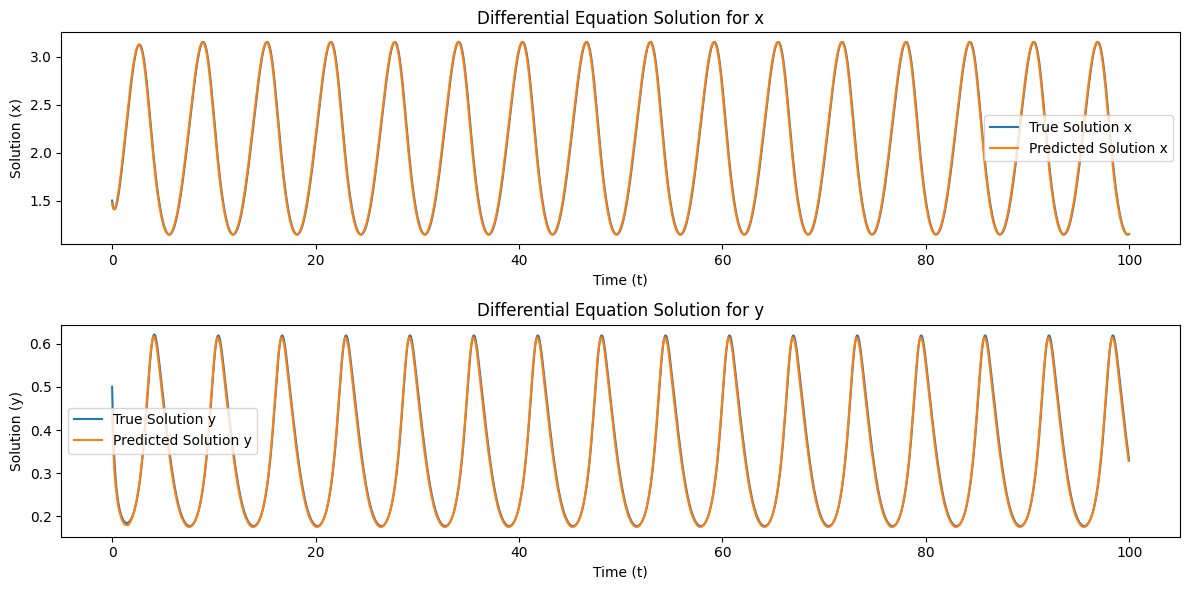

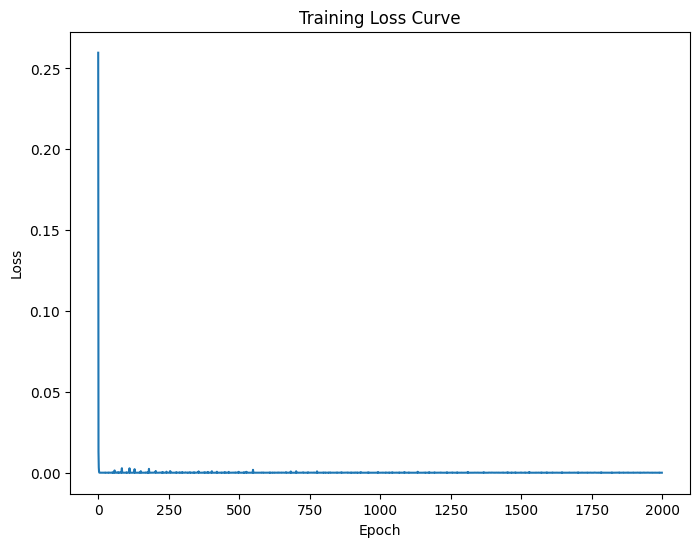

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert data to Pandas DataFrames
df_true_solution_system = pd.DataFrame({'t': t, 'x': true_solution_system[:, 0], 'y': true_solution_system[:, 1]})
df_predicted_solution_system = pd.DataFrame({'t': t[:-1], 'x': predicted_solution_system[:, 0], 'y': predicted_solution_system[:, 1]})
df_loss = pd.DataFrame({'epoch': history_system.epoch, 'loss': history_system.history['loss']})

# Plot true and predicted system solutions
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
sns.lineplot(data=df_true_solution_system, x='t', y='x', label='True Solution x')
sns.lineplot(data=df_predicted_solution_system, x='t', y='x', label='Predicted Solution x')
plt.title('Differential Equation Solution for x')
plt.xlabel('Time (t)')
plt.ylabel('Solution (x)')
plt.legend()

plt.subplot(2, 1, 2)
sns.lineplot(data=df_true_solution_system, x='t', y='y', label='True Solution y')
sns.lineplot(data=df_predicted_solution_system, x='t', y='y', label='Predicted Solution y')
plt.title('Differential Equation Solution for y')
plt.xlabel('Time (t)')
plt.ylabel('Solution (y)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot loss curve during training
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_loss, x='epoch', y='loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [7]:
print(len(true_solution_system[:, 0]))
print(len(true_solution_system[:, 1]))
print(len(t[:-1]))


2000
2000
1999


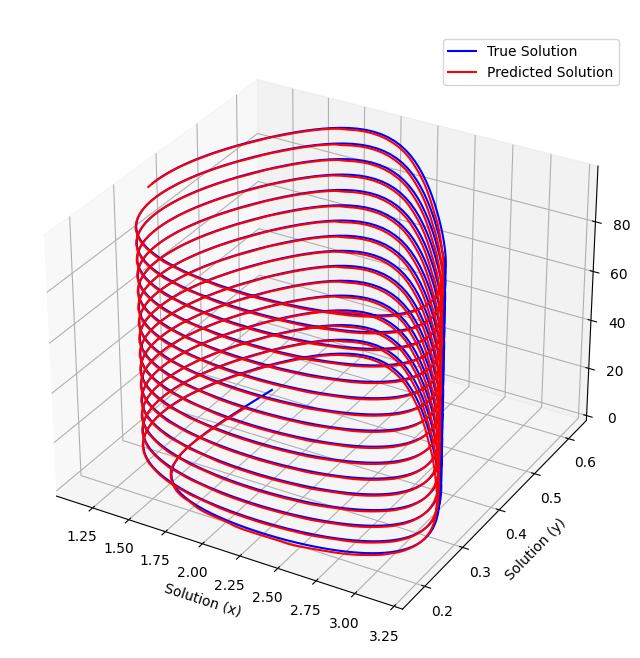

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ensure all arrays have the same length
min_length = min(len(true_solution_system[:, 0]), len(true_solution_system[:, 1]), len(t[:-1]))
true_solution_system = true_solution_system[:min_length]
predicted_solution_system = predicted_solution_system[:min_length]
t = t[:min_length+1]

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot true solution
ax.plot(true_solution_system[:, 0], true_solution_system[:, 1], t[:-1], label='True Solution', color='blue')

# Plot predicted solution
ax.plot(predicted_solution_system[:, 0], predicted_solution_system[:, 1], t[:-1], label='Predicted Solution', color='red')

# Set labels and title
ax.set_xlabel('Solution (x)')
ax.set_ylabel('Solution (y)')
ax.set_zlabel('Time (t)')
ax.set_title(' ')
ax.legend()

plt.show()


In [ ]:
# import numpy as np
# import tensorflow as tf
# import plotly.graph_objects as go
# from scipy.integrate import solve_ivp

# # Define constants
# a1 = 1.0
# a2 = 1.0
# b = 1.0
# r = 1.0

# # Define the PINN model
# class PINNModel(tf.keras.Model):
#     def __init__(self, layer_dims, lb, ub):
#         super(PINNModel, self).__init__()
#         self.lb = lb
#         self.ub = ub
#         self.layer_dims = layer_dims

#         self.weight_params, self.biases = self.initialize_NN(layer_dims)

#     def initialize_NN(self, layer_dims):
#         weight_params = []
#         biases = []
#         num_layers = len(layer_dims)
#         for l in range(0, num_layers - 1):
#             W = self.xavier_init(size=[layer_dims[l], layer_dims[l + 1]])
#             b = tf.Variable(tf.zeros([1, layer_dims[l + 1]], dtype=tf.float32), dtype=tf.float32)
#             weight_params.append(W)
#             biases.append(b)
#         return weight_params, biases

#     def xavier_init(self, size):
#         in_dim = size[0]
#         out_dim = size[1]
#         xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
#         return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

#     def neural_net(self, X):
#         num_layers = len(self.layer_dims)
#         H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
#         for l in range(0, num_layers - 2):
#             W = self.weight_params[l]
#             b = self.biases[l]
#             H = tf.tanh(tf.add(tf.matmul(H, W), b))
#         W = self.weight_params[-1]
#         b = self.biases[-1]
#         Y = tf.add(tf.matmul(H, W), b)
#         return Y

#     def net_u(self, x, t):
#         u = self.neural_net(tf.concat([x, t], 1))
#         return u

#     def net_v(self, x, t):
#         v = self.neural_net(tf.concat([x, t], 1))
#         return v

#     def net_uv(self, x, t):
#         u = self.net_u(x, t)
#         v = self.net_v(x, t)
#         return u, v

# # Define the PINN solver
# def solve_pinn(model, X_u_train, u_train, X_v_train, v_train, optimizer, epochs):
#     for epoch in range(epochs):
#         with tf.GradientTape() as tape:
#             u_pred, v_pred = model.net_uv(X_u_train[:, 0:1], X_u_train[:, 1:2])
#             f_u, f_v = pde_residuals(X_u_train[:, 0:1], X_u_train[:, 1:2], u_pred, v_pred)
#             loss_u = tf.reduce_mean(tf.square(u_train - u_pred))
#             loss_v = tf.reduce_mean(tf.square(v_train - v_pred))
#             loss_f = tf.reduce_mean(tf.square(f_u)) + tf.reduce_mean(tf.square(f_v))
#             loss = loss_u + loss_v + loss_f  # Combined loss

#         gradients_loss_u = tape.gradient(loss_u, model.trainable_variables)
#         gradients_loss_v = tape.gradient(loss_v, model.trainable_variables)
#         gradients_loss_f = tape.gradient(loss_f, model.trainable_variables)

#         gradients = [grad_u + grad_v + grad_f for grad_u, grad_v, grad_f in zip(gradients_loss_u, gradients_loss_v, gradients_loss_f)]

#         optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#         if epoch % 100 == 0:
#             print(f"Epoch {epoch}, Total Loss: {loss.numpy()}, "
#                   f"U Loss: {loss_u.numpy()}, V Loss: {loss_v.numpy()}, F Loss: {loss_f.numpy()}")

# # Define the physics-informed residuals
# def pde_residuals(x, t, u, v):
#     with tf.GradientTape(persistent=True) as tape:
#         tape.watch(x)
#         tape.watch(t)
#         u_x = tape.gradient(u, x)
#         u_xx = tape.gradient(u_x, x)
#         v_x = tape.gradient(v, x)
#         v_xx = tape.gradient(v_x, x)

#     u_t = tape.gradient(u, t)
#     v_t = tape.gradient(v, t)

#     f_u = u_t - a1 * u_xx + u**2 * v - (b + 1) * u + r
#     f_v = v_t - a2 * v_xx - b * u + u**2 * v

#     return f_u, f_v

# # Define the finite element solver
# def solve_finite_element_method():
#     def du2_dx2(u):
#         if isinstance(u, (int, float)) or len(u) == 0:
#             return np.zeros_like(u)  # Return zeros if u is scalar or empty
#         dx = (x_max - x_min) / (len(u) - 1)
#         d2u_dx2 = np.zeros_like(u)
#         d2u_dx2[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
#         return d2u_dx2

#     def pde_system(t, y):
#         u, v = y
#         du_dt = a1 * du2_dx2(u) - u**2 * v + (b + 1) * u - r
#         dv_dt = a2 * du2_dx2(v) - b * u + u**2 * v
#         return [du_dt, dv_dt]

#     # Set initial conditions
#     initial_conditions = [0.5, 1 + 5 * x_min]

#     # Solve the system of PDEs
#     sol = solve_ivp(pde_system, [0, t_max], initial_conditions, t_eval=T)

#     return sol.y

# # Define the domain and time parameters
# x_min, x_max = 0, 1
# t_max = 1
# num_x_points = 100
# num_t_points = 100
# X, T = np.meshgrid(np.linspace(x_min, x_max, num_x_points),
#                    np.linspace(0, t_max, num_t_points))
# X_u_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
# X_v_train = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# # Generate some training data (can be replaced with actual data)
# u_train = np.random.rand(X_u_train.shape[0], 1)
# v_train = np.random.rand(X_v_train.shape[0], 1)

# # Convert training data to TensorFlow tensors
# X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
# u_train_tf = tf.convert_to_tensor(u_train, dtype=tf.float32)
# X_v_train_tf = tf.convert_to_tensor(X_v_train, dtype=tf.float32)
# v_train_tf = tf.convert_to_tensor(v_train, dtype=tf.float32)

# # Define PINN parameters
# layer_dims = [2, 50, 50, 50, 1]
# lb = np.array([x_min, 0])
# ub = np.array([x_max, t_max])

# # Create PINN model
# model = PINNModel(layer_dims, lb, ub)

# # Define optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# # Train the PINN model
# solve_pinn(model, X_u_train_tf, u_train_tf, X_v_train_tf, v_train_tf, optimizer, epochs=1000)

# # Solve PDEs using finite element method
# u_fe, v_fe = solve_finite_element_method()

# # Plot solutions using Plotly
# fig = go.Figure()

# # Plot finite element method solutions
# fig.add_trace(go.Surface(x=X, y=T, z=u_fe, name='u (FE)'))
# fig.add_trace(go.Surface(x=X, y=T, z=v_fe, name='v (FE)'))

# # Plot PINN solutions
# u_pred, v_pred = model.net_uv(tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(T, dtype=tf.float32))
# u_pred_np = u_pred.numpy()
# v_pred_np = v_pred.numpy()
# u_pred_np = np.array(u_pred_np).reshape(X.shape)
# v_pred_np = np.array(v_pred_np).reshape(X.shape)
# fig.add_trace(go.Surface(x=X, y=T, z=u_pred_np, name='u (PINN)'))
# fig.add_trace(go.Surface(x=X, y=T, z=v_pred_np, name='v (PINN)'))

# # Add layout information
# fig.update_layout(title='Solution Comparison',
#                   scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='Value'))

# # Show plot
# fig.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.graph_objects as go

# Define the PINN model with Fourier features
class PINN(keras.Model):
    def __init__(self, num_fourier_features):
        super(PINN, self).__init__()
        self.num_fourier_features = num_fourier_features
        self.dense_u1 = layers.Dense(50, activation='relu')
        self.dense_v1 = layers.Dense(50, activation='relu')
        self.dense_u2 = layers.Dense(50, activation='relu')
        self.dense_v2 = layers.Dense(50, activation='relu')
        self.dense_u3 = layers.Dense(50, activation='relu')
        self.dense_v3 = layers.Dense(50, activation='relu')
        self.dense_t = layers.Dense(2, activation=None)

    def call(self, inputs):
        # Fourier features
        fourier_features = self._fourier_features(inputs[:, 1], self.num_fourier_features)
        inputs = tf.concat([inputs, fourier_features], axis=1)

        x = inputs[:, 0:1]
        t = inputs[:, 1:2]
        uv = tf.concat([x, t], axis=1)
        return self.dense_t(tf.concat([self.dense_u3(self.dense_u2(self.dense_u1(uv))), self.dense_v3(self.dense_v2(self.dense_v1(uv)))], axis=1))

    def _fourier_features(self, x, num_features):
        # Fourier features computation
        t = tf.expand_dims(x, -1)
        frequencies = tf.range(1, num_features + 1, dtype=tf.float32)
        features = tf.concat([tf.sin(np.pi * t * frequencies), tf.cos(np.pi * t * frequencies)], axis=-1)
        return features

# Define loss function
def custom_loss(model):
    def loss_fn(x, t):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            tape.watch(t)
            inputs = tf.concat([x, t], axis=1)
            predictions = model(inputs)
            u = predictions[:, 0:1]
            v = predictions[:, 1:2]
            du_dt = tape.gradient(u, t)
            du_dx = tape.gradient(u, x)
            du_dx2 = tape.gradient(tf.gradients(u, x)[0], x)
            dv_dt = tape.gradient(v, t)
            dv_dx = tape.gradient(v, x)
            dv_dx2 = tape.gradient(tf.gradients(v, x)[0], x)
        del tape

        eq1_residual = du_dt - a1 * du_dx2 - u**2 * v + (b + 1) * u - r
        eq2_residual = dv_dt - a2 * dv_dx2 + u**2 * v - b * u
        ic_loss_u = u - 0.5  # Adjust shape to match model output
        ic_loss_v = v - (1 + 5*x)  # Adjust shape to match model output
        bc_loss_u = du_dx[:, 0:1] - du_dx[:, -1:]
        bc_loss_v = dv_dx[:, 0:1] - dv_dx[:, -1:]

        total_loss = (tf.reduce_mean(tf.square(eq1_residual)) +
                      tf.reduce_mean(tf.square(eq2_residual)) +
                      tf.reduce_mean(tf.square(ic_loss_u)) +
                      tf.reduce_mean(tf.square(ic_loss_v)) +
                      tf.reduce_mean(tf.square(bc_loss_u)) +
                      tf.reduce_mean(tf.square(bc_loss_v)))

        return total_loss
    return loss_fn

# Define parameters
a1 = 0.0001
a2 = 0.0001
b = 3.4
r = 1
num_fourier_features = 100  # Number of Fourier features

# Define training data
x_train = np.linspace(0, 10, 200)[:, None]
t_train = np.linspace(0, 10, 200)[:, None]

# Create PINN model with Fourier features
model = PINN(num_fourier_features)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss(model), metrics=['mse'])

# Train the model
history = model.fit(
    x=np.concatenate([x_train, t_train], axis=1),
    y=np.zeros((len(x_train), 2)),
    epochs=1000,
    batch_size=32,
    verbose=1
)

# Evaluate the model
loss = model.evaluate(
    x=np.concatenate([x_train, t_train], axis=1),
    y=np.zeros((len(x_train), 2))
)
print("Total Loss:", loss)

# Plot true and predicted solutions
x_plot = np.linspace(0, 10, 200)
t_plot = np.linspace(0, 10, 200)
X_plot, T_plot = np.meshgrid(x_plot, t_plot)
inputs_plot = np.column_stack((X_plot.flatten(), T_plot.flatten()))

# Evaluate true solutions
def true_solution(x, t):
    u_true = np.sin(x) * np.cos(t)
    v_true = np.sin(x) * np.sin(t)
    return u_true, v_true

u_true, v_true = true_solution(X_plot, T_plot)

# Predict solutions using trained model
predictions = model.predict(inputs_plot)
u_pred = predictions[:, 0].reshape(X_plot.shape)
v_pred = predictions[:, 1].reshape(X_plot.shape)

# Plot true and predicted solutions for u
fig_u = go.Figure()
fig_u.add_trace(go.Surface(z=u_pred, x=X_plot, y=T_plot, colorscale='Plasma', name='Predicted Solution'))
fig_u.update_layout(title='Solution of u(x, t)',
                    scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='u(x,t)'))
fig_u.show()

# Plot true and predicted solutions for v
fig_v = go.Figure()
fig_v.add_trace(go.Surface(z=v_pred, x=X_plot, y=T_plot, colorscale='Plasma', name='Predicted Solution'))
fig_v.update_layout(title='Solution of v(x, t)',
                    scene=dict(xaxis_title='x', yaxis_title='t', zaxis_title='v(x,t)'))
fig_v.show()


Output hidden; open in https://colab.research.google.com to view.